In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.processing import phase_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "20200706_SMA"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [5]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200719_DCIS_SMA"

test_size=0.2
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, val_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']
print(X_train.shape, X_val.shape)

(66, 512, 512, 3) (17, 512, 512, 3)


X.shape: (66, 512, 512, 3)
y.shape: (66, 512, 512, 1)
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.]


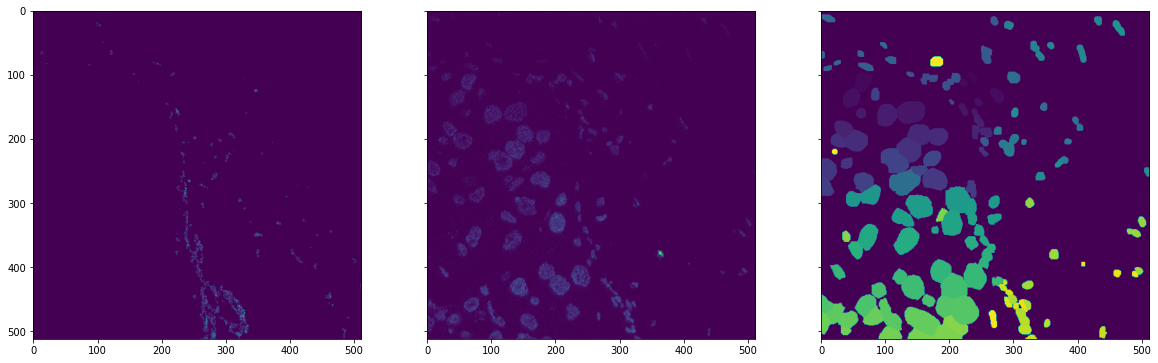

In [6]:
for i in range(y_train.shape[0]):
        y_train[i], _, _ = relabel_sequential(y_train[i])
        
for i in range(y_val.shape[0]):
        y_val[i], _, _ = relabel_sequential(y_val[i])
        
               
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 20), sharex=True, sharey=True)

idx = 4
axes[0].imshow(X_train[idx,:,:,0])
axes[1].imshow(X_train[idx,:,:,1])
axes[2].imshow(y_train[idx,:,:,0])
print(np.unique(y_train[idx]))

In [7]:
k=128
X_train = phase_preprocess(X_train, k)
X_val = phase_preprocess(X_val, k)

In [8]:
from deepcell.model_zoo.panopticnet import PanopticNet

new_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 3),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

W0719 17:06:54.095533 139673637279552 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94773248/94765736 [==============================] - 2s 0us/step


In [9]:
old_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)
old_model.load_weights('/data/models/20200619_production_updates/20200626_all_data_512x512_deep_watershed.h5')

In [10]:
for i, layer in enumerate(new_model.layers):
    if layer.get_weights() == []:
        pass
    if layer.name == 'conv_channels':
        pass
    else:
        old_weights = old_model.layers[i].get_weights()
        new_model.layers[i].set_weights(old_weights)

In [11]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + '_deep_watershed'

n_epoch = 80  # Number of training epochs

optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)

batch_size = 1

min_objects = 3  # throw out images with fewer than this many objects
seed=0
model_name

'20200719_DCIS_SMA_deep_watershed'

In [12]:
X_val.shape

(17, 512, 512, 3)

In [13]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256))

datagen_val = image_generators.CroppingDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0,
    crop_size=(256, 256))
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

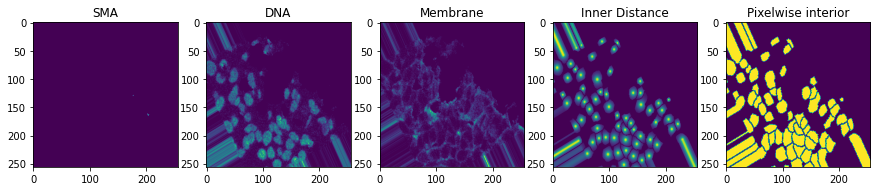

In [44]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]
pixelwise = outputs[3]

fig, axes = plt.subplots(1, 5, figsize=(15, 15))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('SMA')

axes[1].imshow(img[:, :, 1])
axes[1].set_title('DNA')

axes[2].imshow(img[:, :, 2])
axes[2].set_title('Membrane')

axes[3].imshow(inner_distance[0, ..., 0])
axes[3].set_title('Inner Distance')

axes[4].imshow(pixelwise[0, ..., 1])
axes[4].set_title('Pixelwise interior')

plt.show()

In [15]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [16]:
new_model.compile(loss=loss, optimizer=optimizer)

In [17]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = new_model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/80


W0719 17:29:25.373068 139673637279552 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 1/66 [..............................] - ETA: 44:14 - loss: 0.0666 - semantic_0_loss: 0.0199 - semantic_1_loss: 0.0350 - semantic_2_loss: 0.0041 - semantic_3_loss: 0.0077

W0719 17:30:06.281619 139673637279552 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.417454). Check your callbacks.


 2/66 [..............................] - ETA: 22:01 - loss: 0.0611 - semantic_0_loss: 0.0183 - semantic_1_loss: 0.0303 - semantic_2_loss: 0.0044 - semantic_3_loss: 0.0080

W0719 17:30:06.395157 139673637279552 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.276145). Check your callbacks.


 3/66 [>.............................] - ETA: 14:29 - loss: 0.0759 - semantic_0_loss: 0.0233 - semantic_1_loss: 0.0377 - semantic_2_loss: 0.0055 - semantic_3_loss: 0.0094

W0719 17:30:06.513992 139673637279552 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.138107). Check your callbacks.


65/66 [============================>.] - ETA: 0s - loss: 0.0626 - semantic_0_loss: 0.0200 - semantic_1_loss: 0.0304 - semantic_2_loss: 0.0042 - semantic_3_loss: 0.0081
Epoch 00001: val_loss improved from inf to 0.05359, saving model to /data/models/20200706_SMA/20200719_DCIS_SMA_deep_watershed.h5
66/66 [==============================] - 55s 841ms/step - loss: 0.0627 - semantic_0_loss: 0.0201 - semantic_1_loss: 0.0304 - semantic_2_loss: 0.0041 - semantic_3_loss: 0.0080 - val_loss: 0.0536 - val_semantic_0_loss: 0.0169 - val_semantic_1_loss: 0.0261 - val_semantic_2_loss: 0.0035 - val_semantic_3_loss: 0.0071
Epoch 2/80
65/66 [============================>.] - ETA: 0s - loss: 0.0557 - semantic_0_loss: 0.0177 - semantic_1_loss: 0.0267 - semantic_2_loss: 0.0038 - semantic_3_loss: 0.0075
Epoch 00002: val_loss did not improve from 0.05359
66/66 [==============================] - 8s 124ms/step - loss: 0.0555 - semantic_0_loss: 0.0176 - semantic_1_loss: 0.0267 - semantic_2_loss: 0.0037 - semantic

KeyboardInterrupt: 

In [84]:
experiment_folder

'20200706_SMA'

In [86]:
new_model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [18]:
from deepcell_toolbox.processing import phase_preprocess
test_data = np.load('/data/segmentation/20200705_DCIS_SMA/test_fovs_2304.npz')
X_test = test_data['X']
X_test = phase_preprocess(X_test)

In [115]:
X_test_crop = np.zeros_like(X_test)
X_test_crop[..., 0] = X_test[..., 2]
X_test_crop[..., 1:3] = X_test[..., :2]
X_test_crop = X_test_crop[:, 256:, :256, :]

In [128]:
X_test_crop = X_val[:, :256, :256, :]

In [105]:
# from deepcell.applications import MultiplexSegmentation
# app = MultiplexSegmentation(use_pretrained_weights=False)
# # app.model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))
# app.model.load_weights('/data/models/20200610_param_tuning/20200612_all_data_512x512_deep_watershed_all_params.h5')
# model.load_weights('/data/models/20200610_param_tuning/20200612_all_data_512x512_deep_watershed_all_params.h5')

In [135]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
inner_distance, outer_distance, fgbg, pixelwise = new_model.predict(X_test_crop)
input_dict = {'inner-distance': inner_distance, 'pixelwise-interior': pixelwise[..., 1:2]}
labeled_images = deep_watershed_mibi(model_output=input_dict)

# labeled_images = deep_watershed_mibi(model_output=input_dict, interior_threshold=0.3,
#                                      maxima_model_smooth=0, 
#                                      interior_model_smooth=0)

In [30]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries[..., 0] > 0, :] = 1
    
    return overlay_data

In [136]:
RGB_data = make_color_overlay(X_test_crop)
predicted_overlay = make_outline_overlay(RGB_data, labeled_images)
# true_overlay = make_outline_overlay(RGB_data, y_test_crop[..., 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  


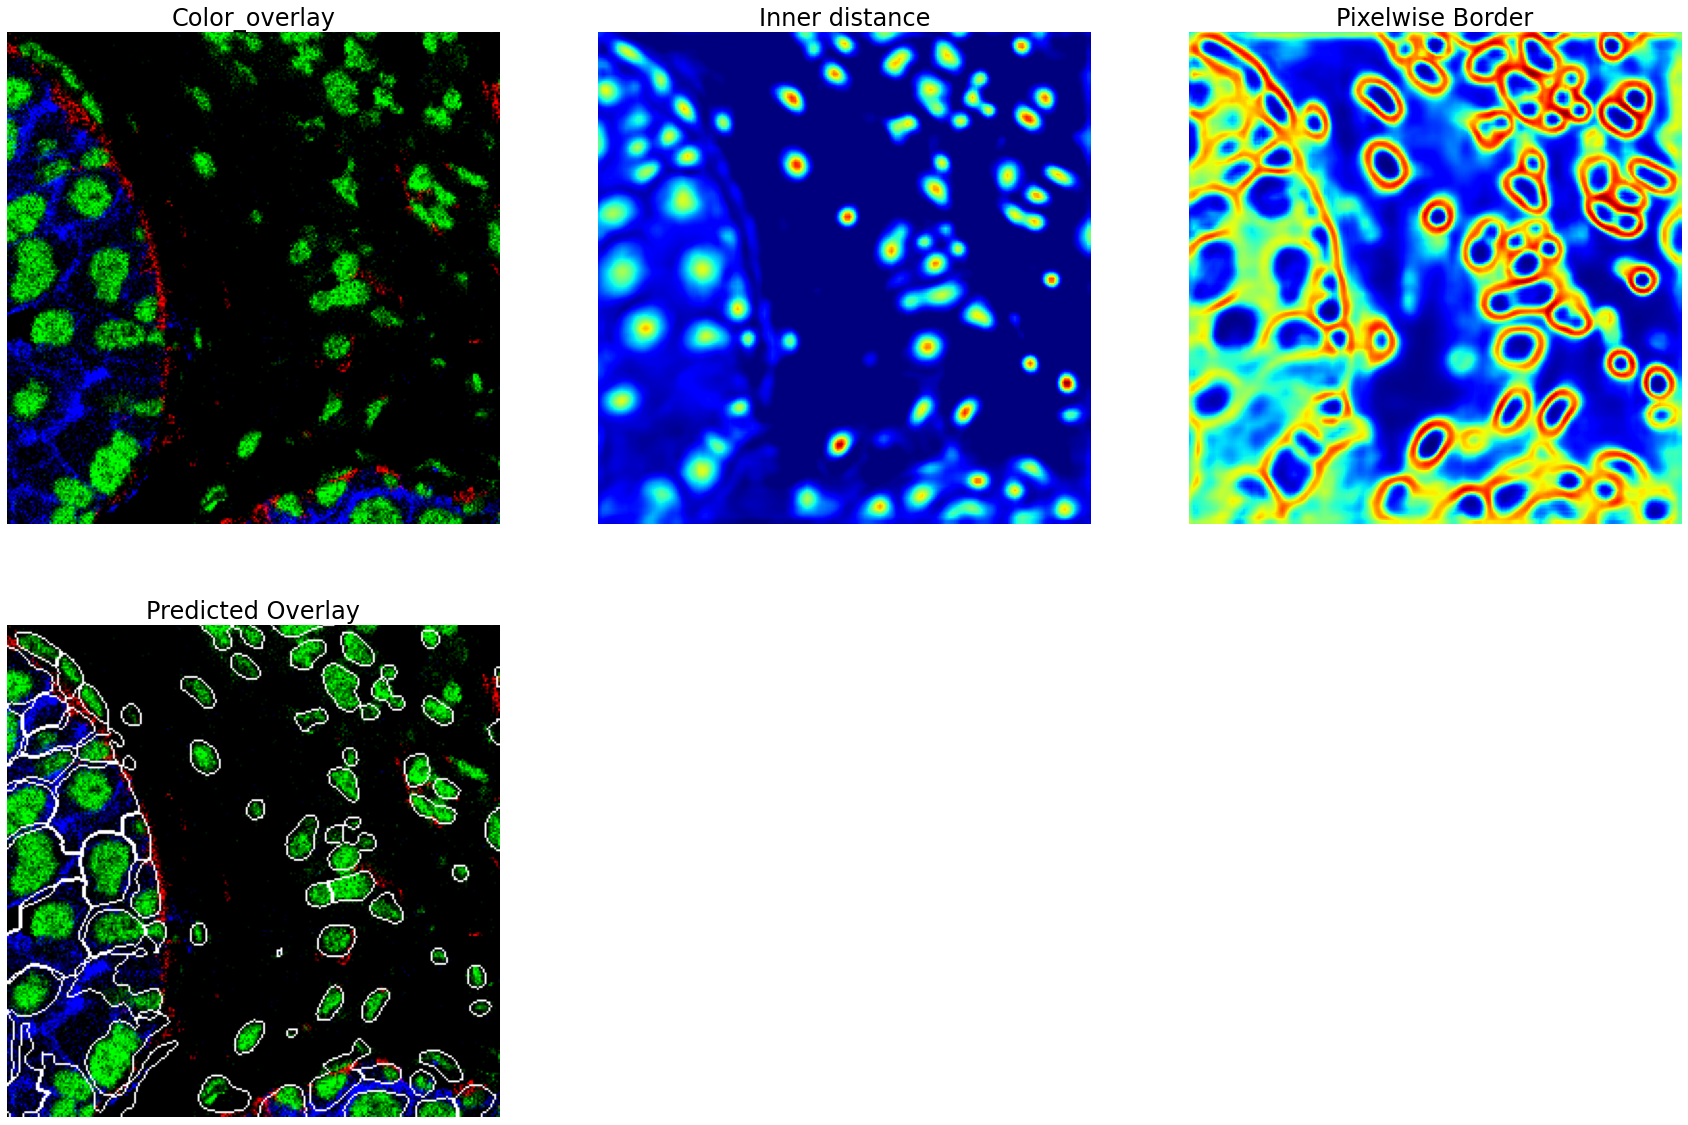

In [121]:
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = [0]
fig, axes = plt.subplots(2,3,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(RGB_data[index[0],...])
axes[1].imshow(inner_distance[index[0],...,0], cmap='jet')
axes[2].imshow(pixelwise[index[0],...,0], cmap='jet')
axes[3].imshow(predicted_overlay[index[0], ...], cmap=cmap)
# axes[4].imshow(true_overlay[index[0], ...], cmap=cmap)

axes[0].set_title('Color_overlay', fontsize=24)
axes[1].set_title('Inner distance', fontsize=24)
axes[2].set_title('Pixelwise Border', fontsize=24)
axes[3].set_title('Predicted Overlay', fontsize=24)
# axes[4].set_title('True Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

IndexError: index 17 is out of bounds for axis 0 with size 17

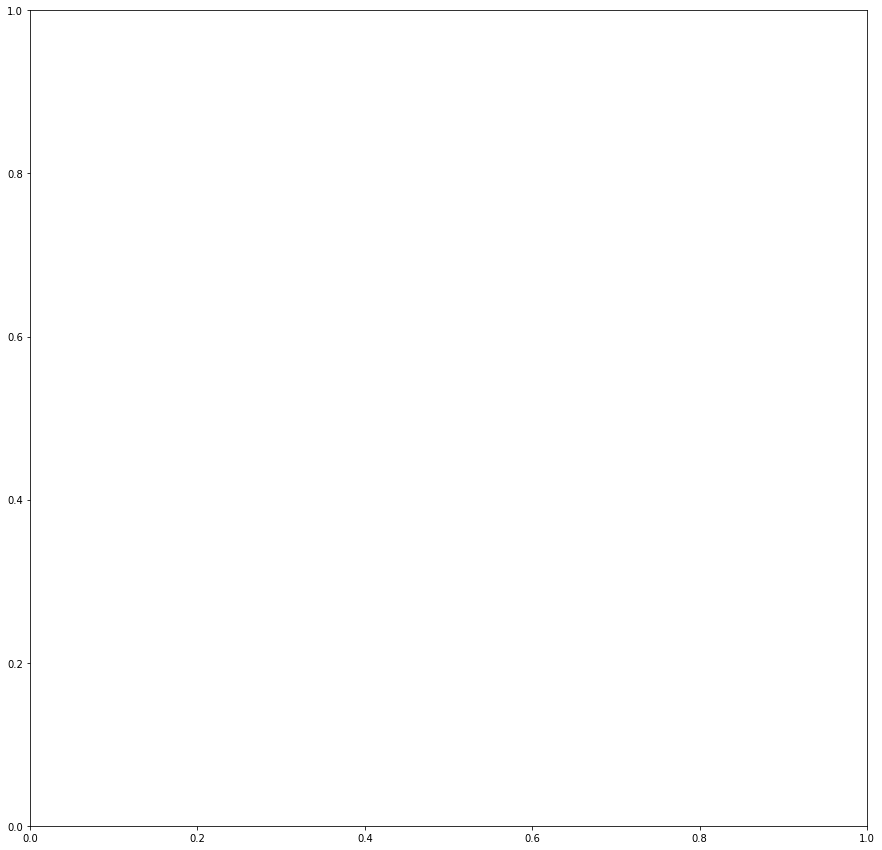

In [151]:
fig, axes = plt.subplots(figsize=(15,15))
axes.imshow(predicted_overlay[17, ...], cmap=cmap)
